## 2018-19 NBA Regular Season Box Score Data

This data comes from https://www.nbastuffer.com/2018-2019-nba-player-stats/ for the 2018-19 regular season.

In [1]:
import pandas as pd

df = pd.read_csv('2018-2019_NBA_Player_Stats.csv')
df

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,Tor%,FTA,...,RPG,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG
0,Alex Abrines,Okc,G,25.69,31,19.0,39.5,12.2,7.9,13,...,1.5,4.2,0.6,4.3,0.55,0.19,0.45,3.5,103.1,103.9
1,Quincy Acy,Pho,F,28.51,10,12.3,25.6,9.2,15.2,10,...,2.5,11.3,0.8,8.2,0.10,0.40,0.40,4.9,87.1,98.5
2,Jaylen Adams,Atl,G,22.93,34,12.6,26.2,13.5,19.7,9,...,1.8,7.5,1.9,20.2,0.38,0.15,0.82,7.0,99.5,108.1
3,Steven Adams,Okc,C,25.73,80,33.4,69.5,16.4,12.8,292,...,9.5,14.7,1.6,6.6,1.49,0.96,1.73,7.1,119.9,102.7
4,Bam Adebayo,Mia,C-F,21.73,82,23.3,48.6,15.8,17.1,226,...,7.3,16.6,2.2,14.2,0.88,0.79,1.48,9.0,120.0,97.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,Tyler Zeller,Atl,C,29.23,2,5.4,11.1,7.6,0.0,0,...,3.0,29.5,0.5,10.9,0.00,0.00,0.00,0.0,82.4,74.1
618,Tyler Zeller,Mem,C,29.23,4,20.6,42.8,21.7,10.0,18,...,4.5,12.3,0.8,6.2,0.25,0.75,1.00,6.7,126.8,93.4
619,Ante Zizic,Cle,C,22.27,59,18.3,38.2,18.2,13.8,132,...,5.4,16.4,0.9,7.7,0.22,0.37,1.05,7.3,116.2,108.1
620,Ivica Zubac,Lal,C,22.07,33,15.6,32.6,20.5,12.9,66,...,4.9,16.3,0.8,7.3,0.15,0.82,1.00,8.3,120.7,97.9


In [2]:
len(df['FULL NAME'].unique())

530

Let's add a few useful columns and check the calculations for effective field goal percentage and true shooting percentage.

In [3]:
df['2PM'] = df['2PA'] * df['2P%']
df['3PM'] = df['3PA'] * df['3P%']
df['FGM'] = df['2PM'] + df['3PM']
df['FGA'] = df['2PA'] + df['3PA']
df['PTS'] = df['PPG'] * df['GP']
df['MINS'] = df['MPG'] * df['GP']

# Calculations according to Wikipedia
df['TEST_EFG%'] = (df['FGM'] + 0.5 * df['3PM']) / df['FGA']
df['TEST_TS%'] = df['PTS'] / (df['FGA'] + 0.44 * df['FTA']) / 2

df[['TEST_EFG%', 'eFG%', 'TEST_TS%', 'TS%']].describe()

,TEST_EFG%,eFG%,TEST_TS%,TS%
count,616.000000,616.000000,616.000000,616.000000
mean,0.500508,0.500511,0.531756,0.531511
std,0.123471,0.123478,0.118519,0.118573
min,0.000000,0.000000,0.000000,0.000000
25%,0.468168,0.468000,0.500000,0.500000
50%,0.511060,0.511000,0.545095,0.545000
75%,0.552833,0.553000,0.581737,0.583000
max,1.500000,1.500000,1.500000,1.500000


We see that the calculated stats and provided stats are quite close. The errors can be attributed to rounding.

We want to filter out players with low minute totals as their sample size is small and may lead to unreliable statistics. To do this, we will need to first combine rows for players who played for several teams.

First, I make a list of the players that appear multiple times, and those who don't.

In [4]:
repeated = []
unique = []
for name, count in df['FULL NAME'].value_counts().iteritems():
    if count >= 2:
        repeated.append(name)
    else:
        unique.append(name)
len(repeated)

86

As we can see, 86 players played for multiple teams during this season. Let us make sure that these duplicates are all the same player, and not two players with the same name, by ensuring that the ages match.

In [5]:
for player in repeated:
    temp = df[df['FULL NAME'] == player]
    if len(temp['AGE'].unique()) != 1:
        print(player, temp['TEAM'].unique())

Indeed, whenever a player name appears multiple times, it is because the same player has played for several teams during the course of the season. During this season, there were no two players in the NBA with the same name. Now, we can construct a new dataframe with only the repeated players. Attention must be paid to the way different stats can be combined. Note that for teams and positions, I kept a list of the values per player.

In [6]:
new_df = pd.DataFrame()
for player in repeated:
    temp = df[df['FULL NAME'] == player]
    d = {}
    for col in df.columns:
        if col in ('GP', 'FTA', '2PA', '3PA', '2PM', '3PM', 'FGM', 'FGA', 'PTS', 'MINS'):
            d[col] = [temp[col].sum()]
        elif col in ('MPG', 'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TOPG'):
            d[col] = [(temp[col] * temp['GP']).sum() / temp['GP'].sum()]
        elif col in ('MIN%', 'USG%', 'Tor%', 'TRB%', 'AST%', 'VI', 'ORTG', 'DRTG'): # Note: VI = versatility index
            d[col] = [(temp[col] * temp['MPG'] * temp['GP']).sum() / (temp['MPG'] * temp['GP']).sum()]
        elif col in ('FT%', '2P%', '3P%'):
            d[col] = [((temp[col] * temp[col[:-1] + 'A']).sum() / temp[col[:-1] + 'A'].sum() * 100) if temp[col[:-1] + 'A'].sum() else 0]
        elif col == 'eFG%':
            d[col] = [(temp[col] * temp['FGA']).sum() / temp['FGA'].sum()]            
        elif col == 'TS%':
            denom = (temp['FGA'] + 0.44 * temp['FTA'])
            d[col] = [(temp[col] * denom).sum() / denom.sum()] 
        else:
            d['FULL NAME'] = temp['FULL NAME'].unique()[0]
            d['AGE'] = [temp['AGE'].unique()[0]]
            d['TEAM'] = [list(temp['TEAM'].unique())]
            d['POS'] = [list(temp['POS'].unique())]

    new_df = new_df.append(pd.DataFrame(data=d))

new_df

,FULL NAME,AGE,TEAM,POS,GP,MPG,MIN%,USG%,Tor%,FTA,...,TOPG,VI,ORTG,DRTG,2PM,3PM,FGM,FGA,PTS,MINS
0,Andrew Harrison,24.47,"[Mem, Cle, Nor]",[G],17,10.958824,25.975845,16.928019,16.477295,18,...,0.704706,6.253140,95.818357,101.200483,11.000,4.996,15.996,53,54.0,186.3
0,Isaiah Canaan,27.89,"[Pho, Min, Mil]",[G],30,20.906667,49.116964,14.307015,16.872832,24,...,1.168667,6.075765,102.222959,112.166454,29.992,33.976,63.968,164,181.4,627.2
0,Greg Monroe,28.85,"[Tor, Bos, Phi]",[C],43,11.141860,24.475078,22.691171,13.237383,72,...,0.765349,7.839386,105.762617,93.549092,90.939,1.000,91.939,189,229.5,479.1
0,Alec Burks,27.73,"[Uta, Cle, Sac]",[G],64,21.467188,51.077684,18.989563,11.043999,141,...,1.013906,7.386469,106.766097,110.209062,131.081,60.978,192.059,474,559.3,1373.9
0,Jason Smith,33.11,"[Was, Mil, Nor]",[F-C],20,9.540000,20.554088,17.457862,16.295597,16,...,0.647000,7.523270,102.071069,98.503145,11.989,8.999,20.988,59,65.6,190.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Delon Wright,26.96,"[Tor, Mem]",[G],75,22.633333,50.459918,18.090680,10.966103,150,...,1.030400,8.249155,112.256495,105.152825,192.030,49.938,241.968,558,655.3,1697.5
0,Tyler Dorsey,23.15,"[Atl, Mem]",[G],48,14.550000,35.375644,19.693299,8.523582,61,...,0.562500,7.004510,104.026031,108.066237,63.000,44.022,107.022,264,294.9,698.4
0,Bobby Portis,24.16,"[Chi, Was]",[F],50,25.948000,54.280222,24.607723,9.946138,97,...,1.482400,8.381733,105.008663,103.195668,203.927,74.957,278.884,628,710.6,1297.4
0,Pau Gasol,38.76,"[San, Mil]",[C-F],30,11.990000,25.129358,15.496747,12.701334,40,...,0.535000,10.553545,115.227857,101.234779,36.036,5.999,42.035,94,117.3,359.7


This dataframe now contains 86 rows, as expected. We can go ahead and merge it with the rows of players who only appear once.

In [7]:
df = df.drop(columns=['TEST_EFG%', 'TEST_TS%'])
merge_df = df[df['FULL NAME'].isin(unique)].append(new_df)
merge_df

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,Tor%,FTA,...,TOPG,VI,ORTG,DRTG,2PM,3PM,FGM,FGA,PTS,MINS
0,Alex Abrines,Okc,G,25.69,31,19.000000,39.500000,12.200000,7.900000,13,...,0.450000,3.500000,103.100000,103.900000,15.000,41.021,56.021,157,164.3,589.0
1,Quincy Acy,Pho,F,28.51,10,12.300000,25.600000,9.200000,15.200000,10,...,0.400000,4.900000,87.100000,98.500000,2.001,1.995,3.996,18,17.0,123.0
2,Jaylen Adams,Atl,G,22.93,34,12.600000,26.200000,13.500000,19.700000,9,...,0.820000,7.000000,99.500000,108.100000,12.996,25.012,38.008,110,108.8,428.4
3,Steven Adams,Okc,C,25.73,80,33.400000,69.500000,16.400000,12.800000,292,...,1.730000,7.100000,119.900000,102.700000,480.972,0.000,480.972,809,1112.0,2672.0
4,Bam Adebayo,Mia,C-F,21.73,82,23.300000,48.600000,15.800000,17.100000,226,...,1.480000,9.000000,120.000000,97.200000,276.948,3.000,279.948,486,729.8,1910.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Delon Wright,"[Tor, Mem]",[G],26.96,75,22.633333,50.459918,18.090680,10.966103,150,...,1.030400,8.249155,112.256495,105.152825,192.030,49.938,241.968,558,655.3,1697.5
0,Tyler Dorsey,"[Atl, Mem]",[G],23.15,48,14.550000,35.375644,19.693299,8.523582,61,...,0.562500,7.004510,104.026031,108.066237,63.000,44.022,107.022,264,294.9,698.4
0,Bobby Portis,"[Chi, Was]",[F],24.16,50,25.948000,54.280222,24.607723,9.946138,97,...,1.482400,8.381733,105.008663,103.195668,203.927,74.957,278.884,628,710.6,1297.4
0,Pau Gasol,"[San, Mil]",[C-F],38.76,30,11.990000,25.129358,15.496747,12.701334,40,...,0.535000,10.553545,115.227857,101.234779,36.036,5.999,42.035,94,117.3,359.7


This merged dataframe contains 520 rows, as expected. We can now consider how to filter out low sample sizes. First let's look at the distribution of minutes played.

count     530.000000
mean     1121.632830
std       838.680755
min         0.700000
25%       323.025000
50%      1066.300000
75%      1834.000000
max      3025.800000
Name: MINS, dtype: float64


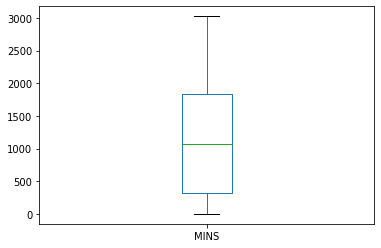

In [8]:
print((merge_df['MINS']).describe())
(merge_df['MINS']).plot.box()

Players who played less than 5 minutes per game were unlikely to be important role players, so their minutes were probably during garbage time. This means that their stats do not necessarily reflect what their performance would be like in normal play. I choose to remove these rows.

In [9]:
print(merge_df.shape[0])
merge_df = merge_df[merge_df['MPG'] > 5]
print(merge_df.shape[0])

530
498


48 players have been removed using this approach. Next, we should also remove players whose sample size is small because they played few games (i.e. their total minutes played will be low).

In [10]:
print(merge_df.shape[0])
merge_df = merge_df[(merge_df['MINS']) > 150]
print(merge_df.shape[0])

498
440


In [12]:
merge_df.isnull().sum()

FULL NAME    0
TEAM         0
POS          0
AGE          0
GP           0
MPG          0
MIN%         0
USG%         0
Tor%         0
FTA          0
FT%          0
2PA          0
2P%          0
3PA          0
3P%          0
eFG%         0
TS%          0
PPG          0
RPG          0
TRB%         0
APG          0
AST%         0
SPG          0
BPG          0
TOPG         0
VI           0
ORTG         0
DRTG         0
2PM          0
3PM          0
FGM          0
FGA          0
PTS          0
MINS         0
dtype: int64

Another 58 players have been removed.

### Question

Should we stick with the merged rows for individual players who played on multiple teams? That would mean we assume that their play style does not change from team to team.

Perhaps a better approach would be to leave the rows separate, remove low-sample ones, and verify after performing the clustering whether any players appear in multiple clusters. This may provide some insight about the algorithm and players.